### разминка
напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
массив чисел от 0 до N - numpy.arange(N)

In [2]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N)**2)

In [3]:
%%time
sum_squares(10**8)

Wall time: 514 ms


-1452071552

### theano teaser

Как сделать то же самое

In [4]:
import theano
import theano.tensor as T

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [5]:
#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')

#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N],outputs=result)

In [6]:
%%time
sum_function(10**8)

Wall time: 986 ms


array(662921401752298880L, dtype=int64)

#### Как оно работает?
Нужно написать "рецепт" получения выходов по входам

То же самое на заумном: нужно описать символический граф вычислений

2 вида зверей - "входы" и "преобразования"

Оба могут быть числами, массивами, матрицами, тензорами и т.п.

Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.

N - вход в примере выше

Преобразования - рецепты вычисления чего-то на основе входов и констант

(T.arange(N)^2).sum() - 3 последовательных преобразования N

Работают почти 1 в 1 как векторные операции в numpy


почти всё, что есть в numpy есть в theano tensor и называется так же

np.mean -> T.mean

np.arange -> T.arange

np.cumsum -> T.cumsum

и так далее...

Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла

Ничего не понятно? Сейчас исправим.

In [7]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится

input_vector = T.vector("вход - вектор целых чисел", dtype='int32')

In [8]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector

In [9]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [10]:
# теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("вход - вектор чисел", dtype='float32')
my_vector2 = T.vector("вход - вектор чисел", dtype='float32')

In [11]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector*my_vector2/(T.sin(my_vector) + 1)

In [12]:
print (my_transformation)
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


#### Компиляция
До этого момента, мы использовали "символические" переменные
писали рецепт вычислений, но ничего не вычисляли
чтобы рецепт можно было использовать, его нужно скомпилироват

In [13]:
inputs = [my_vector, my_vector2]
outputs = my_transformation

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs, outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [14]:
#можно вызвать вот-так:
print ("using python lists:")
print (my_function([1,2,3],[4,5,6]))
print()

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print ("using numpy arrays:")
print (my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))

using python lists:
[  2.1721766    5.2375288   15.77397633]
()
using numpy arrays:
[   0.            2.77555895    5.47030783   14.02131271   89.5477066
  676.25775146   47.183918     24.40843201   23.68156242   38.24041748]


#### хинт для отладки
Если ваша функция большая, компиляция может отнять какое-то время.
Чтобы не ждать, можно посчитать выражение без компиляции
Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее

In [15]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print ("сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs))

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print ("форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    }))

[  2.1721766    5.2375288   15.77397633]
('\xd1\x81\xd1\x83\xd0\xbc\xd0\xbc\xd0\xb0 2 \xd0\xb2\xd0\xb5\xd0\xba\xd1\x82\xd0\xbe\xd1\x80\xd0\xbe\xd0\xb2', array([ 5.,  7.,  9.], dtype=float32))
('\xd1\x84\xd0\xbe\xd1\x80\xd0\xbc\xd0\xb0 \xd0\xbf\xd0\xb5\xd1\x80\xd0\xb2\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xb2\xd0\xb5\xd0\xba\xd1\x82\xd0\xbe\xd1\x80\xd0\xb0', array([3], dtype=int64))


### Теперь сам: MSE (2 pts)

In [16]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

input_vector = T.vector("вход - вектор чисел", dtype='float32')
input_vector2 = T.vector("вход - вектор чисел", dtype='float32')

my_transformation = T.sum((input_vector - input_vector2)**2)/input_vector.size

compute_mse = theano.function(
    [input_vector, input_vector2], my_transformation,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [17]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")

All tests passed


#### Shared variables
Входы и преобразования - части рецепта.
Они существуют только во время вызова функции.
Shared переменные - всегда остаются в памяти
им можно поменять значение
(но не внутри символического графа. Об этом позже)
их можно включить в граф вычислений
хинт - в таких переменных удобно хранить параметры и гиперпараметры
например, веса нейронки или learning rate, если вы его меняете

In [18]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [19]:
#получить (численное) значение переменной
print ("initial value",shared_vector_1.get_value())

('initial value', array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


In [20]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print ("new value", shared_vector_1.get_value())

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

('new value', array([ 0.,  1.,  2.,  3.,  4.]))


#### Теперь сам

In [21]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = shared_vector_1*input_scalar

shared_times_n = theano.function(
    [input_scalar], scalar_times_shared,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [22]:
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))

('shared:', array([ 0.,  1.,  2.,  3.,  4.]))
('shared_times_n(5)', array([  0.,   5.,  10.,  15.,  20.]))
('shared_times_n(-0.5)', array([-0. , -0.5, -1. , -1.5, -2. ]))


In [23]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))

('shared:', array([-1.,  0.,  1.]))
('shared_times_n(5)', array([-5.,  0.,  5.]))
('shared_times_n(-0.5)', array([ 0.5, -0. , -0.5]))


### T.grad, самое вкусное
theano умеет само считать производные. Все, которые существуют.
Производные считаются в символическом, а не численном виде
Ограничения
За раз можно считать производную скалярной функции по одной или нескольким скалярным или векторным аргументам
Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [24]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative)

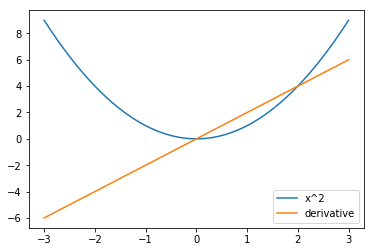

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = list(map(fun,x))
x_squared_der = list(map(grad,x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

### теперь сам

In [26]:
my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector) 


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)

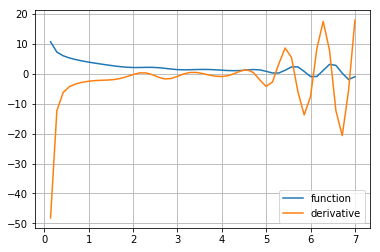

In [27]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()

### Последний штрих - Updates
updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции
фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции
Например,

In [28]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [29]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print ("initial shared value:" ,shared_vector_1.get_value())

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print ("compute_and_save(2) returns",compute_and_save(2))

#проверим, что в shared_vector_1
print ("new shared value:" ,shared_vector_1.get_value())

('initial shared value:', array([ 0.,  1.,  2.,  3.,  4.]))
('compute_and_save(2) returns', [array([ 0.,  2.,  4.,  6.,  8.])])
('new shared value:', array([ 0.,  2.,  4.,  6.,  8.]))


#### Логистическая регрессия
Что нам потребуется:
Веса лучше хранить в shared-переменной
Данные можно передавать как input
Нужно 2 функции:
train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту (через updates)
predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [30]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print ("y [форма - %s]:"%(str(y.shape)),y[:10])

print ("X [форма - %s]:"%(str(X.shape)))
print (X[:3])

('y [\xd1\x84\xd0\xbe\xd1\x80\xd0\xbc\xd0\xb0 - (360L,)]:', array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]))
X [форма - (360L, 64L)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1

In [31]:
# переменные и входы
shared_weights = theano.shared(np.zeros(len(y),dtype='float64'))
input_X = theano.
#input_y = <твой код>

SyntaxError: invalid syntax (<ipython-input-31-26276af2c160>, line 3)

#### lasagne
lasagne - это библиотека для написания нейронок произвольной формы на theano
библиотека низкоуровневая, границы между theano и lasagne практически нет
В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
картинки 28x28
10 цифр

### Тут пришлось скопипастить код функции, потому что по-другому не запускается(((

In [32]:

import sys
import os

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    #if sys.version_info[0] == 2:
    from urllib import urlretrieve
    #else:
        #from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [33]:
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

((50000L, 1L, 28L, 28L), (50000L,))


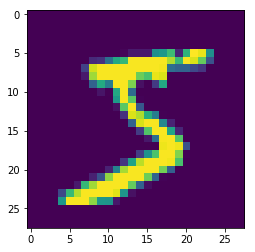

In [34]:
plt.imshow(X_train[0,0])

In [35]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [36]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')

In [37]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [38]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


#### дальше вы могли бы просто
задать функцию ошибки вручную

посчитать градиент ошибки по all_weights

написать updates

но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [39]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()


accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [40]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

#### Вот и всё, пошли её учить
данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [44]:
from random import shuffle
import math

# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать X и y одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batch_size картинок и ответов
# - если число картинок не делится на batch_size, одну подгруппу можно вернуть другого размера
# 4) вернуть список (или итератор) пар:
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(X, y, batchsize):
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]
    
    #return X_minibatches, Y_minibatches # можно сделать списки, а ещё лучше - генератором через yield 
    
# Всё плохо и ты не понимаешь, что от тебя хотят?
# можешь поискать похожую функцию в примере
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

In [45]:
#iterate_minibatches(X_train, y_train, 5000)

### Процесс обучения (здесь он очень долго учится :((((( )

In [46]:
import time
from tqdm import tqdm

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [185]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

4
10
18


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [190]:
mnist

<module 'mnist' from 'C:\Program Files\Anaconda3\envs\py27\lib\site-packages\mnist\__init__.pyc'>